In [1]:
# 加载相关数据库
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #用于排除警告
from sklearn.decomposition import PCA #主成分降维
from sklearn.preprocessing import StandardScaler #数据标准化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
# 1 加载数据集
dataset = pd.read_csv('./data/Mall_Customers.csv')
d=dataset
dataset.head(10) #Printing first 10 rows of the dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [3]:
# 2 数据分析
dataset.shape

(200, 5)

In [4]:
# 观察有无缺失值
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


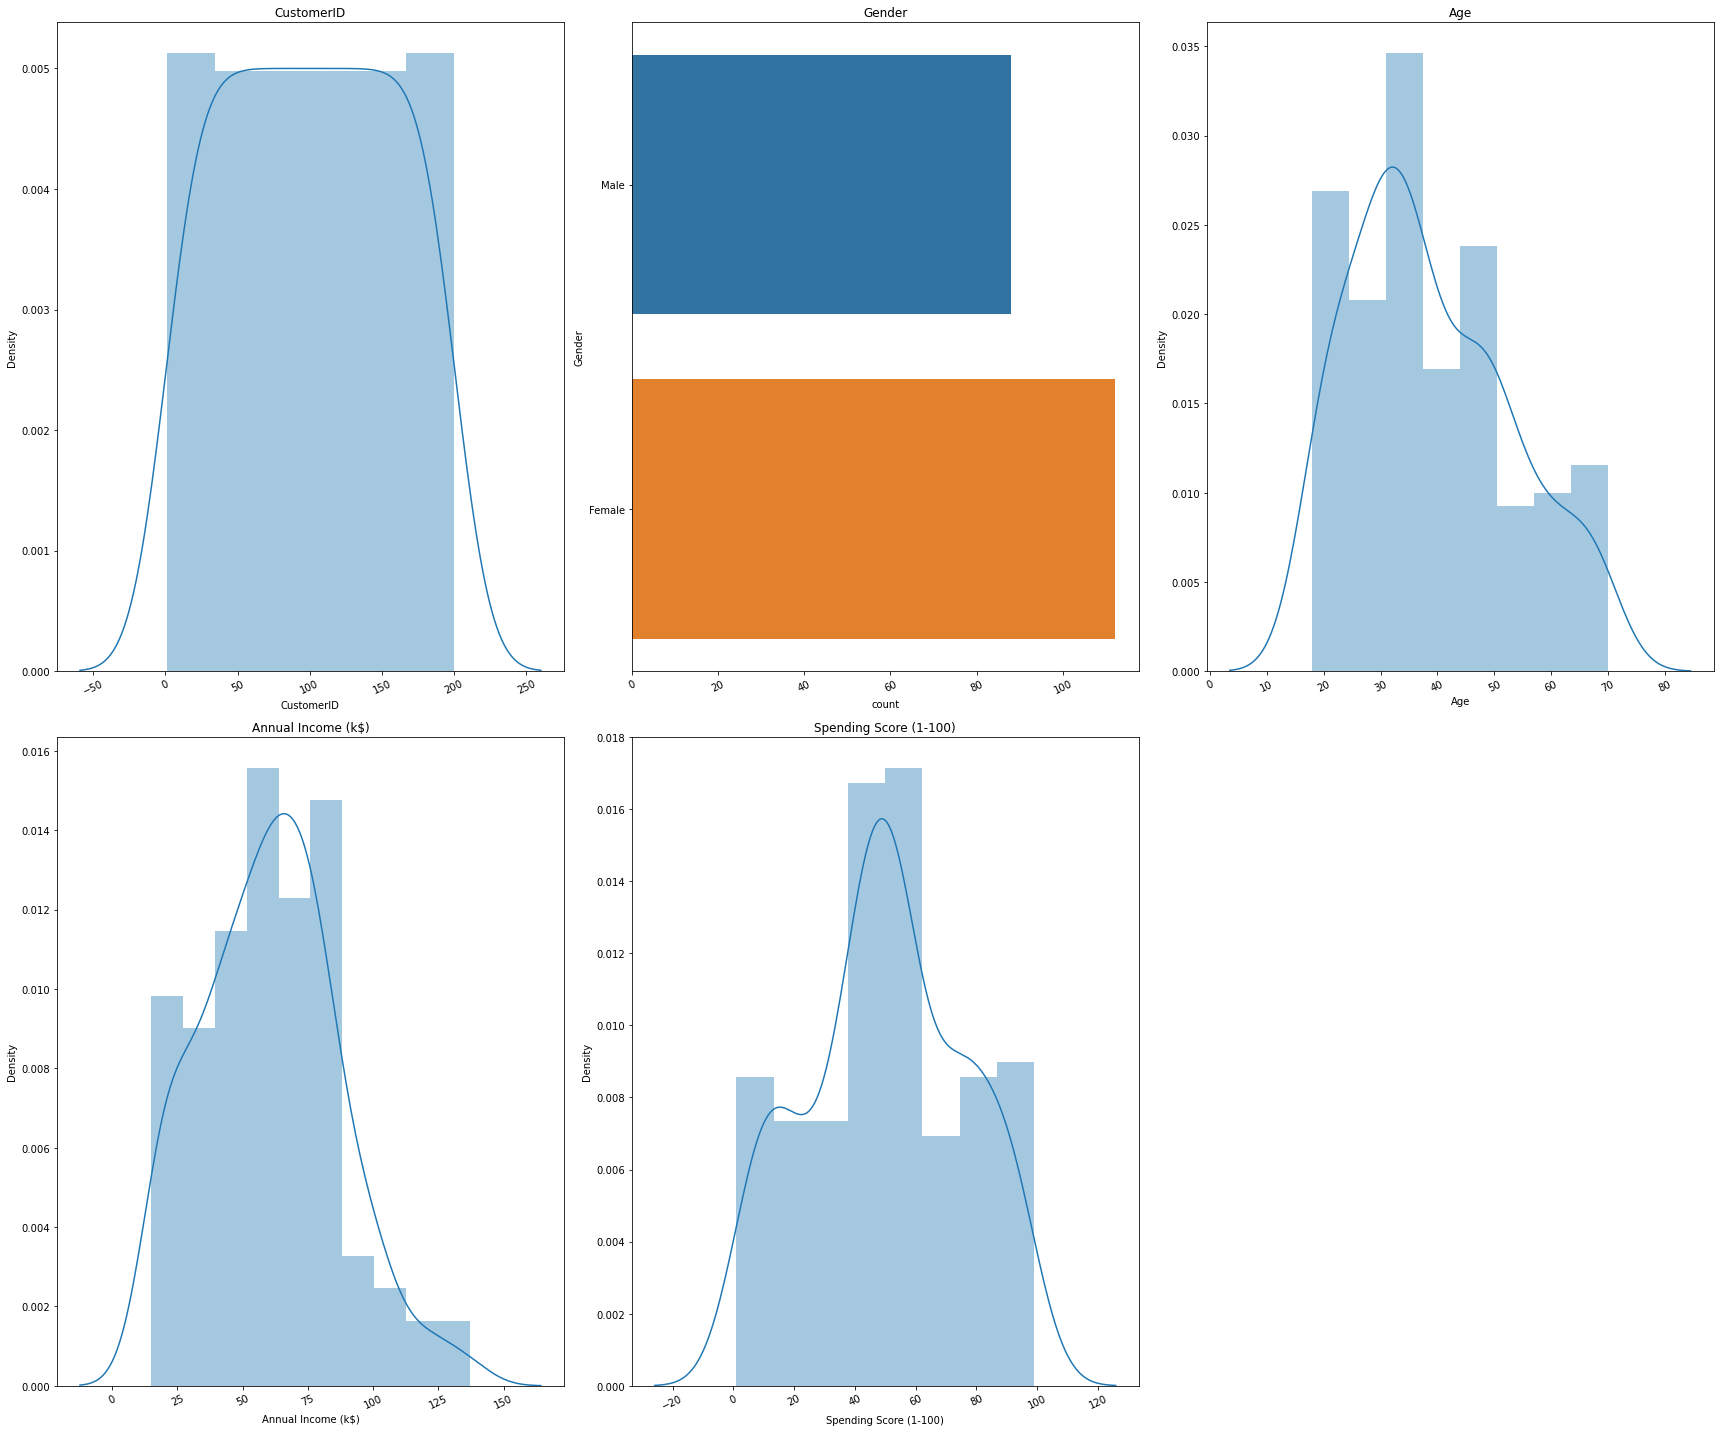

In [5]:
# 数据可视化
import math
def plot_distribution(dataset, cols, width, height, hspace, wspace):
    fig = plt.figure(figsize = (width, height))
    fig.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=wspace,hspace=hspace)
    rows = math.ceil(dataset.shape[1] / cols)
    for i,column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            plt.xticks(rotation = 25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation = 25)
    plt.tight_layout()
plot_distribution(dataset, cols=3, width=24, height=20, hspace=0.2, wspace=0.5)

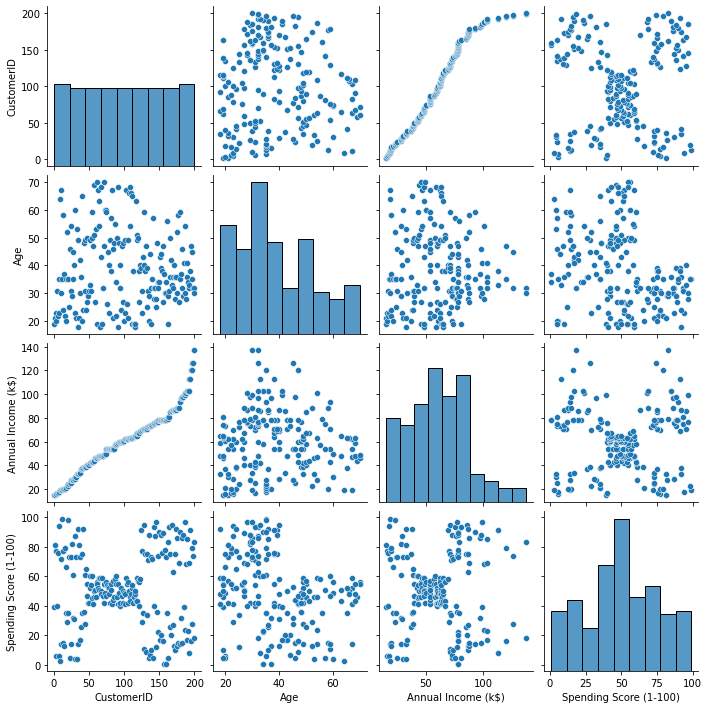

In [6]:
sns.pairplot(dataset)

In [7]:
# 改Sex列的值
dataset.loc[dataset['Gender']=='Male','Gender'] = 0
dataset.loc[dataset['Gender']=='Female','Gender'] = 1
# 改数据类型，否则corr会不计算该列
dataset['Gender']=dataset['Gender'].astype(np.int)
# 去掉ID列，没有用
dataset=dataset.drop('CustomerID',axis=1)

transfer0 = StandardScaler() #实例化一个转换器类
xi = transfer0.fit_transform(dataset) #调用fit_transform()
data2 = pd.DataFrame(xi,columns=dataset.columns)

Gender                    1.000000
Spending Score (1-100)    0.058109
Annual Income (k$)       -0.056410
Age                      -0.060867
Name: Gender, dtype: float64


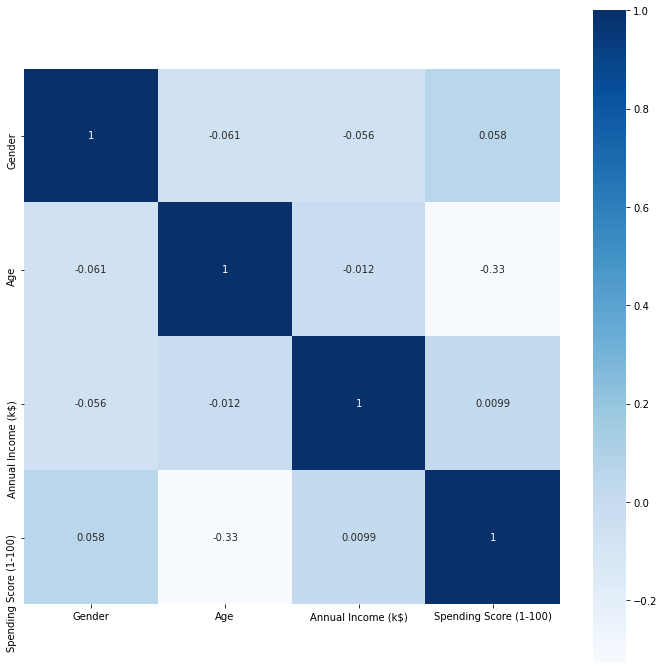

In [8]:
# 查找关联度
corr_matrix = data2.corr()
print(corr_matrix['Gender'].sort_values(ascending=False))
# 展示各特征之间的相关性
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, vmax=1, square=True, cmap='Blues')
plt.show()

In [9]:
# 找找离群点
Q1 = dataset['Annual Income (k$)'].quantile(0.25)
Q3 = dataset['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

In [10]:
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
print('low_limit is', low_lim)
print('up_limit is', up_lim)

low_limit is -13.25
up_limit is 132.75


发现离群点，处理他

In [11]:
outlier = []
for x in dataset['Annual Income (k$)']:
    if ((x > up_lim) or (x < low_lim)):
         outlier.append(x)
print('Outlier in the dataset is', outlier)

Outlier in the dataset is [137, 137]


In [12]:
dataset.loc[dataset['Annual Income (k$)'] >= 137, 'Annual Income (k$)'] = dataset['Annual Income (k$)'].mean()

<AxesSubplot:ylabel='Annual Income (k$)'>

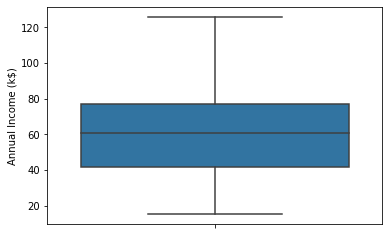

In [13]:
sns.boxplot(y="Annual Income (k$)", data=dataset)


<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

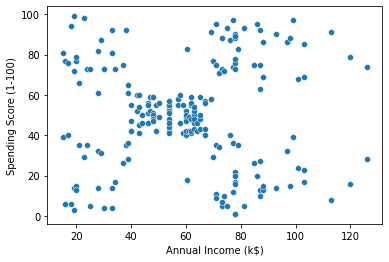

In [14]:
sns.scatterplot(x="Annual Income (k$)",
                    y="Spending Score (1-100)",
                    data=dataset)

### 一眼看上去这么分是有五类的

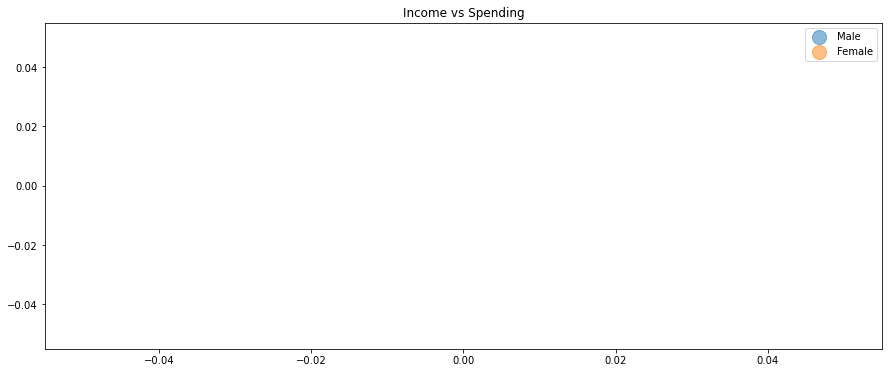

In [15]:
#  再用性别看看
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = d[d['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.title("Income vs Spending")
plt.legend()


Text(0.5, 1.0, 'Gender wise spending score')

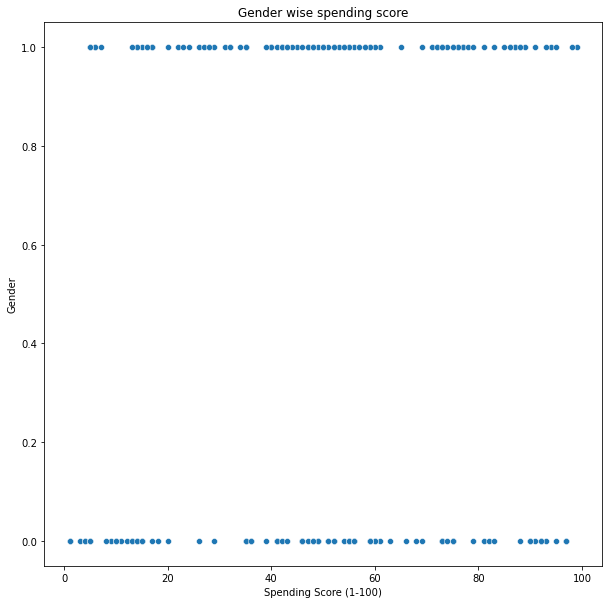

In [16]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Spending Score (1-100)', y='Gender', data=dataset)
plt.title("Gender wise spending score")

### 显然性别这个特征不能用

### 再看看年龄

Text(0.5, 1.0, 'Age vs Spending score')

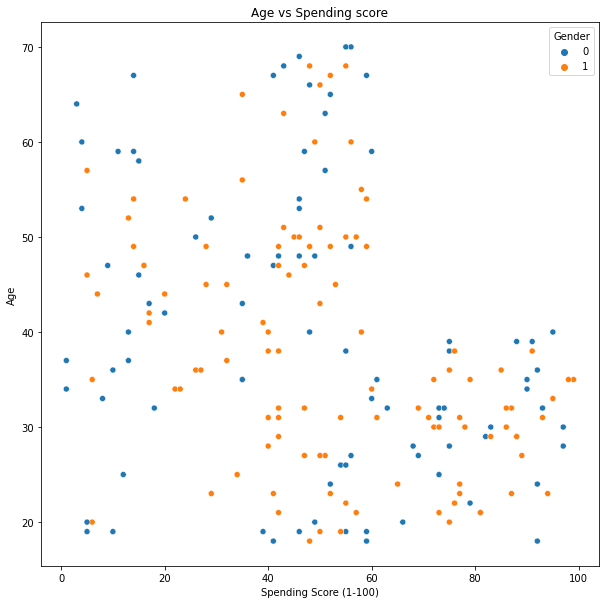

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Spending Score (1-100)', y='Age', hue="Gender", data=dataset)
plt.title("Age vs Spending score")

### 也不行

In [18]:
#选择最优质心点


Text(0, 0.5, 'Silhouette Coefficient Score')

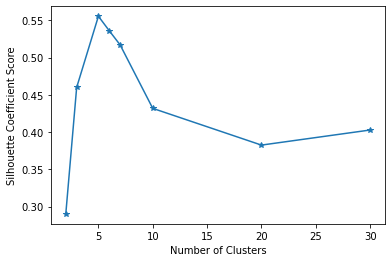

In [19]:
# 聚类,找最优K值
from sklearn.metrics import silhouette_score

b=dataset.iloc[:,2:4]
b=b.values
clusters = [2,3,5,6,7,10,20,30]  
sc_scores=[]
#簇的个数
for t in clusters:
    Clu=KMeans(n_clusters=t,init='random',n_init=10,max_iter=300,random_state=0)
    y_clu=Clu.fit_predict(b)
    sc_score = silhouette_score(b, y_clu)
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')

###  5作为K值是最佳的

# 画图

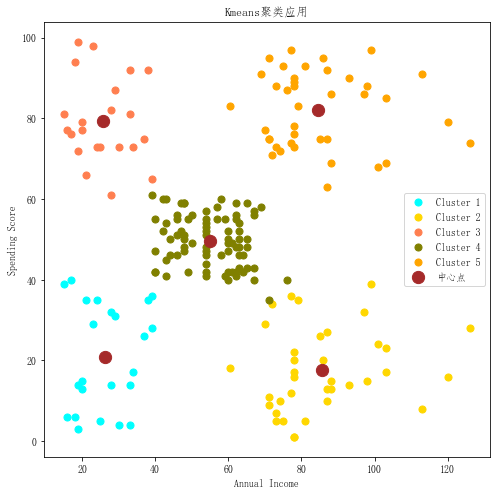

In [20]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

Clu=KMeans(n_clusters=5,init='random',n_init=10,max_iter=300,random_state=0)
y_clu=Clu.fit_predict(b)
# Means

plt.figure(figsize=(8,8))
plt.scatter(b[y_clu==0,0], b[y_clu==0,1], s=50, c='cyan', label='Cluster 1')
plt.scatter(b[y_clu==1,0], b[y_clu==1,1], s=50, c='gold', label='Cluster 2')
plt.scatter(b[y_clu==2,0], b[y_clu==2,1], s=50, c='coral', label='Cluster 3')
plt.scatter(b[y_clu==3,0], b[y_clu==3,1], s=50, c='olive', label='Cluster 4')
plt.scatter(b[y_clu==4,0], b[y_clu==4,1], s=50, c='orange', label='Cluster 5')
plt.scatter(Clu.cluster_centers_[:,0], Clu.cluster_centers_[:,1], s=150, c='brown', label='中心点')
plt.legend()
plt.title('Kmeans聚类应用')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

In [21]:
### 网上学到的好作图
b

array([[ 15.  ,  39.  ],
       [ 15.  ,  81.  ],
       [ 16.  ,   6.  ],
       [ 16.  ,  77.  ],
       [ 17.  ,  40.  ],
       [ 17.  ,  76.  ],
       [ 18.  ,   6.  ],
       [ 18.  ,  94.  ],
       [ 19.  ,   3.  ],
       [ 19.  ,  72.  ],
       [ 19.  ,  14.  ],
       [ 19.  ,  99.  ],
       [ 20.  ,  15.  ],
       [ 20.  ,  77.  ],
       [ 20.  ,  13.  ],
       [ 20.  ,  79.  ],
       [ 21.  ,  35.  ],
       [ 21.  ,  66.  ],
       [ 23.  ,  29.  ],
       [ 23.  ,  98.  ],
       [ 24.  ,  35.  ],
       [ 24.  ,  73.  ],
       [ 25.  ,   5.  ],
       [ 25.  ,  73.  ],
       [ 28.  ,  14.  ],
       [ 28.  ,  82.  ],
       [ 28.  ,  32.  ],
       [ 28.  ,  61.  ],
       [ 29.  ,  31.  ],
       [ 29.  ,  87.  ],
       [ 30.  ,   4.  ],
       [ 30.  ,  73.  ],
       [ 33.  ,   4.  ],
       [ 33.  ,  92.  ],
       [ 33.  ,  14.  ],
       [ 33.  ,  81.  ],
       [ 34.  ,  17.  ],
       [ 34.  ,  73.  ],
       [ 37.  ,  26.  ],
       [ 37.  ,  75.  ],


In [22]:
Clu=KMeans(n_clusters=5,init='random',n_init=10,max_iter=300,random_state=0)
model=Clu.fit(b)
y_clu=model.predict(b)

In [23]:
h = 0.02
x_min, x_max = b[:, 0].min() - 1, b[:, 0].max() + 1
y_min, y_max = b[:, 1].min() - 1, b[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = Clu.predict(np.c_[xx.ravel(), yy.ravel()]) 

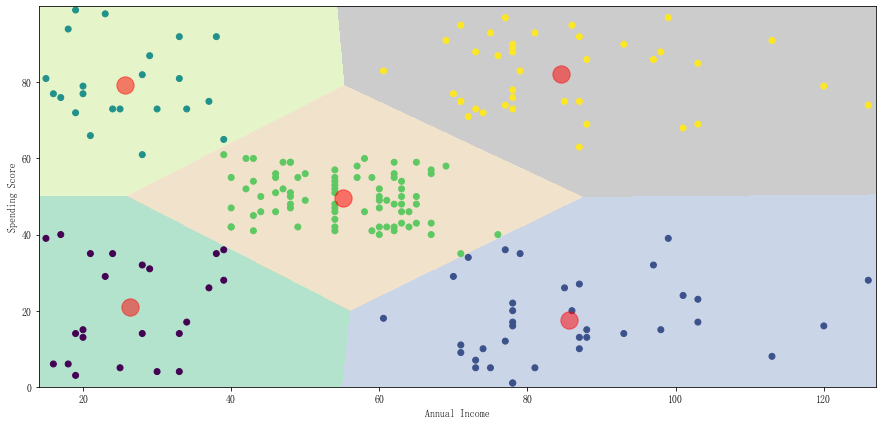

In [24]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)

plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(b[:,0],b[:,1],c=y_clu)
centers = model.cluster_centers_

plt.scatter(x = centers[: , 0] , y =  centers[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

### 聚类效果还可以,完成任务，分成了五类人员

# 完成